In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,auc,accuracy_score
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
con = sqlite3.connect("database.sqlite") 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
import gensim

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [5]:
filtered_data.head


<bound method NDFrame.head of             Id   ProductId          UserId  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW   
1            2  B00813GRG4  A1D87F6ZCVE5NK   
2            3  B000LQOCH0   ABXLMWJIXXAIN   
3            4  B000UA0QIQ  A395BORC6FGVXV   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T   
5            6  B006K2ZZ7K   ADT0SRK1MGOEU   
6            7  B006K2ZZ7K  A1SP2KVKFXXRU1   
7            8  B006K2ZZ7K  A3JRGQVEQN31IQ   
8            9  B000E7L2R4  A1MZYO9TZK0BBI   
9           10  B00171APVA  A21BT40VZCCYT4   
10          11  B0001PB9FE  A3HDKO7OW0QNK4   
11          12  B0009XLVG0  A2725IB4YY9JEB   
12          13  B0009XLVG0   A327PCT23YH90   
13          14  B001GVISJM  A18ECVX2RJ7HUE   
14          15  B001GVISJM  A2MUGFV2TDQ47K   
15          16  B001GVISJM  A1CZX3CP8IKQIJ   
16          17  B001GVISJM  A3KLWF6WQ5BNYO   
17          18  B001GVISJM   AFKW14U97Z6QO   
18          19  B001GVISJM  A2A9X58G2GTBLP   
19          20  B001GVISJM  A3IV7CL2C13K2U   
20  

In [6]:
import nltk
nltk.download('stopwords')
sno=nltk.stem.SnowballStemmer('english')
stop = set(stopwords.words('english'))
def cleanhtml(sentence):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr,' ',sentence)
  return cleantext
def cleanpunc(sentence):
  cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned) 
  return cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))   

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'why', 'of', 'each', 'has', 'is', 'it', 'her', 'or', 'some', 'mustn', 'here', 'through', 'were', "you'd", 'mightn', 'needn', 'more', 'haven', 'their', 'am', 'itself', 'our', 'they', 've', 'but', 'y', 't', 'she', 'can', "hadn't", 'weren', "it's", 'was', "mightn't", 'been', 'yourself', 'during', 'now', "haven't", 'myself', 'whom', 'yourselves', "don't", 'we', 'below', 'again', 'wouldn', "shan't", 'above', 'up', 'most', 'isn', 'what', 'between', 'where', 'that', 'few', 'to', "she's", 'own', "hasn't", 'nor', 'further', 'which', 'hasn', 'i', 'll', 'as', "mustn't", 'are', 'yours', 'from', 'you', "shouldn't", 'who', 'shan', 'off', 'for', 'wasn', 'he', 'only', 'its', 'this', 'himself', 'hadn', 'because', 'and', "wasn't", 'me', 'couldn', 'had', 'if', 'after', 'be', "needn't", 'out', 'him', 'down', 'once', 'in', 'his', 'other', 'all', '

In [7]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Time based splitting

In [9]:
import datetime
from tqdm import tqdm

In [10]:
final['Time'] = final['Time'].map(lambda t:datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

In [11]:
final["Time"].head()

138706    1999-10-08 05:30:00
138688    2007-11-11 05:30:00
138689    2007-10-04 05:30:00
138690    2004-02-06 05:30:00
138691    2002-04-10 05:30:00
Name: Time, dtype: object

In [12]:
final=final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [18]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
      
  


100%|██████████| 364171/364171 [06:09<00:00, 985.31it/s] 


In [13]:
final_string = openfromfile('final_string')

In [0]:
savetofile(final_string,'final_string')

In [0]:
savetofile(all_positive_words,'all_positive_words')

In [0]:
savetofile(all_negative_words,'all_negative_words')

In [14]:
len(final_string)

364171

In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [16]:
final_sample=final['CleanedText'].values[0:100000]
final_score=final['Score'].values[0:100000]

# FUNCTION FOR KMEANS classifier

In [ ]:

def KMEANS(X_train,X_test,optimum_k):
   
    from sklearn.cluster import KMeans
    from sklearn.metrics.pairwise import euclidean_distances
    distance=euclidean_distances(X_train)
    clf=KMeans(n_clusters=optimum_k)
    clf.fit(X_train)
    pred = clf.predict(X_test)
    labels=clf.labels_
    diameter = np.zeros(6)
    for i in np.arange(0,X_train.shape[0]):
        
        for j in np.arange(i+1,len(labels)):
            
            if labels[i]==labels[j] and distance[i,j]> diameter[labels[j]]:
                
                diameter[labels[j]]= distance[i,j]
            
            
    print(diameter)   
   


# ELBOW METHOD FOR  OPTIMAL K

In [16]:
class Point:
        import math
        def __init__(self,initx,inity):
            self.x = initx
            self.y = inity
        def getX(self):
            return self.x
        def getY(self):
            return self.y
        def __str__(self):
            return "x=" + str(self.x) + ", y=" + str(self.y)
        def distance_from_point(self,the_other_point):
            dx = the_other_point.getX() - self.x
            dy = the_other_point.getY() - self.y
        def slope(self,other_point):
            if self.x - other_point.getX() == 0 :
                return 0
            else:
                panta = (self.y - other_point.getY())/ (self.x - other_point.getX())
                return panta
        def distance_to_line(self, p1, p2):
            import math
            x_diff = p2.x - p1.x
            y_diff = p2.y - p1.y
            num = abs(y_diff*self.x - x_diff*self.y + p2.x*p1.y - p2.y*p1.x)
            den = math.sqrt(y_diff**2 + x_diff**2)
            return num / den      
                

In [16]:
def optimal_k(X_train):
    from sklearn.cluster import KMeans
    K_values = list(range(1,11))

    loss_value = []
    
    for k in tqdm(K_values):
        
     
        clf = KMeans(n_clusters = k,init='k-means++')
        
        clf.fit(X_train)
        loss_value.append(clf.inertia_)

   

    Minimum_loss=[x for x in loss_value]
    plt.figure(figsize=(10,6))
    plt.plot(list(range(1,11)),Minimum_loss,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('loss value vs. K Value')
    plt.xlabel('K')
    plt.ylabel('loss value')

    print("the minimum loss for each k value is : ", np.round(Minimum_loss,3))
    wcss = []
    distances = []
    for w in range(0,10): 
        import math
        p1 = Point(initx=1,inity=loss_value[0])
        p2 = Point(initx=10,inity=loss_value[9])
        p = Point(initx=w+1,inity=loss_value[w])
        distances.append(p.distance_to_line(p1,p2))
    
    Minimum_dist=[x for x in distances]
    print("the most optimal value for k is : ", K_values[distances.index(max(distances))])

# Bag of words -(LINEAR CLASSIFIER)

In [18]:
X_train = final['CleanedText'].values[0:100000]


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,1))
Vocabulary = count_vect.fit_transform(X_train)


In [18]:
bow_X_train=count_vect.transform(X_train)


In [19]:
from sklearn import preprocessing 
bow_X_train= preprocessing.normalize(bow_X_train)


In [20]:
bow_X_train.shape

(100000, 37164)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [2:10:13<00:00, 834.26s/it]


the minimum loss for each k value is :  [94619.522 93073.55  92101.735 91283.76  90512.706 89902.471 89408.183
 88922.434 88539.208 88174.807]
the most optimal value for k is :  5


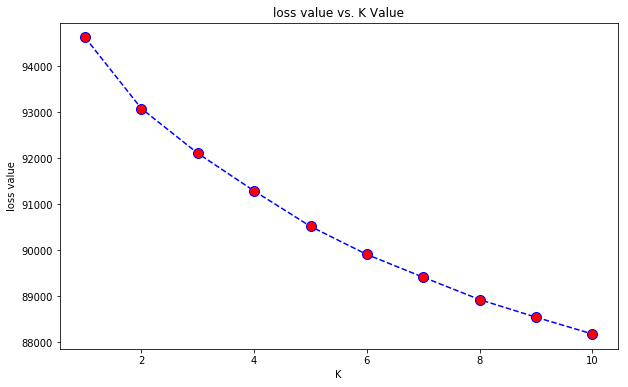

In [276]:
optimal_k(bow_X_train)

# KMEANS CLASSIFIER for BOW

In [21]:
from sklearn.cluster import KMeans

clf=KMeans(n_clusters=5)
clf.fit(bow_X_train)
mydict = {i: np.where(clf.labels_ == i)[0] for i in range(5)}

In [22]:
savetofile(clf,'Kmeans_bow')

In [21]:
clf = openfromfile('Kmeans_bow')

In [33]:
mydict

{0: array([    0,     1,     2, ..., 99992, 99995, 99999], dtype=int64),
 1: array([   48,    63,    70, ..., 99993, 99994, 99997], dtype=int64),
 2: array([   18,    33,    38, ..., 99987, 99996, 99998], dtype=int64),
 3: array([   57,   128,   141, ..., 99954, 99971, 99990], dtype=int64),
 4: array([   11,    12,    13, ..., 99960, 99977, 99991], dtype=int64)}

word cluster for  1 cluster


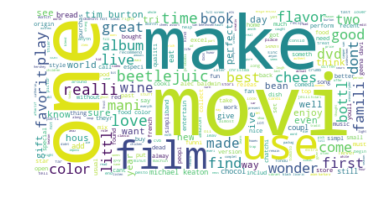

word cluster for  2 cluster


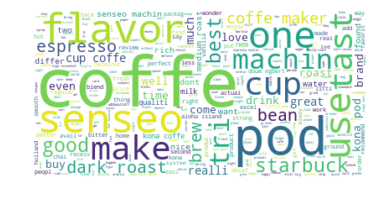

word cluster for  3 cluster


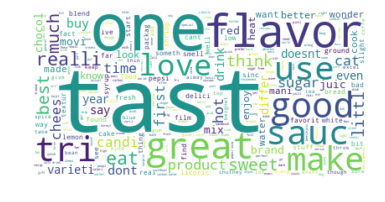

word cluster for  4 cluster


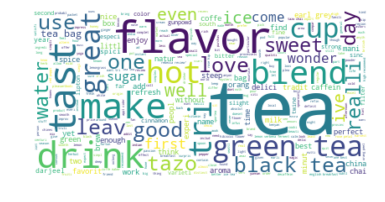

word cluster for  5 cluster


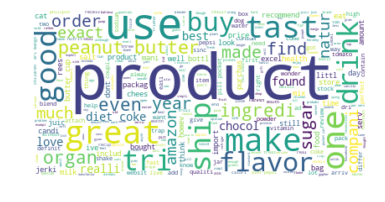

In [34]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


for i  in range (0,len(mydict)):
    wordlist=[]
    terms =list(mydict[i])
    for j in range(0,len(terms[0:100])):
        wordlist.append(X_train[terms[j]])
        
        
    
    wc = WordCloud(background_color="white", max_words=len(str(wordlist)), stopwords=stopwords)
    wc.generate(str(wordlist))
    print('word cluster for ',i+1 ,'cluster')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


<h3>Conclusions</h3>
<ol><li>
here first cluster represents movie ,books,film review 
</li>
<li>
here second cluster represent taste reviews of coffee , tea etc
</li>
<li>here third cluster represents food reviews like of chees,chocolate
<li>
here fourth cluster represents drinks reviews    </li>
<li>
    here fifth cluster represents food reviews of peanutbutter , diet coke etc</li></ol>


## Linear Classifier for TFIDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
Vocabulary = tfidf_vect.fit_transform(X_train)


In [20]:
tfidf_X_train=tfidf_vect.transform(X_train)


In [21]:
from sklearn import preprocessing 
tfidf_X_train= preprocessing.normalize(tfidf_X_train)


In [22]:
tfidf_X_train.shape

(100000, 37164)

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [2:45:34<00:00, 1228.05s/it]


the minimum loss for each k value is :  [97610.233 96769.867 96194.439 95814.999 95523.021 95247.638 95042.668
 94797.643 94619.555 94437.762]
the most optimal value for k is :  4


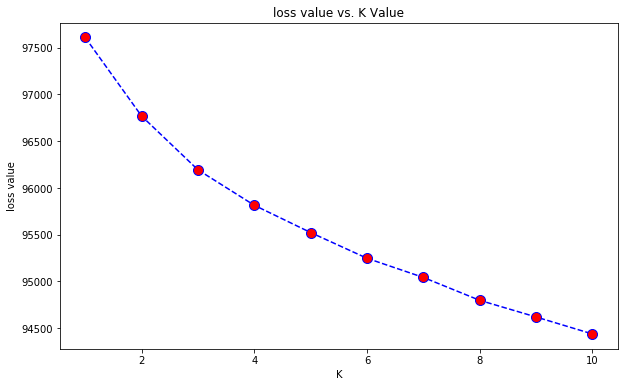

In [282]:
optimal_k(tfidf_X_train)

In [23]:
from sklearn.cluster import KMeans

clf=KMeans(n_clusters=4)
clf.fit(tfidf_X_train)
mydict = {i: np.where(clf.labels_ == i)[0] for i in range(4)}

word cluster for  1 cluster


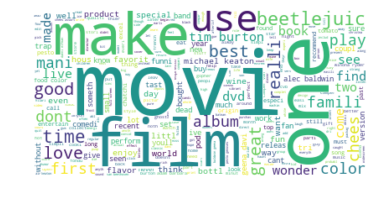

word cluster for  2 cluster


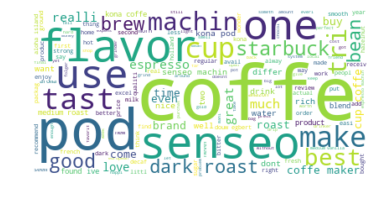

word cluster for  3 cluster


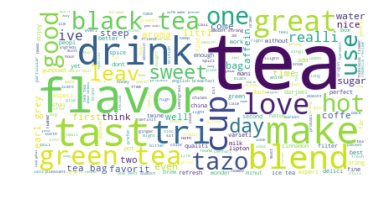

word cluster for  4 cluster


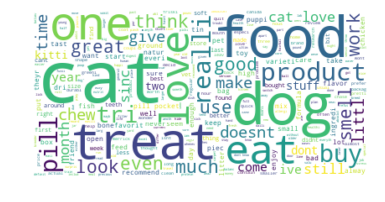

In [24]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


for i  in range (0,len(mydict)):
    wordlist=[]
    terms =list(mydict[i])
    for j in range(0,len(terms[0:100])):
        wordlist.append(X_train[terms[j]])
        
        
    
    wc = WordCloud(background_color="white", max_words=len(str(wordlist)), stopwords=stopwords)
    wc.generate(str(wordlist))
    print('word cluster for ',i+1 ,'cluster')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


<h3>Conclusions</h3>
<ol><li>
here first cluster represents movie ,books,film review 
</li>
<li>
here second cluster represent taste reviews of coffee , tea etc
</li>
<li>here third cluster represents food reviews of various beverages
<li>
here fourth cluster represents animal food reviews    </li>
</ol>

# Word 2 vec

In [25]:
i=0
list_of_sent100=[]
for sent in tqdm(X_train):
    
    list_of_sent100.append(sent.split())

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [06:36<00:00, 252.18it/s]


In [26]:
w2v_model100 = gensim.models.Word2Vec(list_of_sent100,min_count=5,size=100, workers=4)

In [28]:
w2v_model100.most_similar("like")

[('weird', 0.6036534309387207),
 ('prefer', 0.5694594979286194),
 ('dislik', 0.5576387643814087),
 ('hate', 0.5479490756988525),
 ('good', 0.5443496704101562),
 ('remind', 0.5375636219978333),
 ('fake', 0.5366352796554565),
 ('gross', 0.5350527763366699),
 ('okay', 0.534812331199646),
 ('love', 0.5264440178871155)]

In [29]:
w2v_words = list(w2v_model100.wv.vocab)


In [30]:
sent_vectors = []; 
for sent in tqdm(list_of_sent100): 
    sent_vec = np.zeros(100)
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model100.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:36<00:00, 173.46it/s]


100000
100


In [31]:
X_train_sent = sent_vectors

# AVG WORD2VEC

In [32]:
final_w2v_sample = np.array(sent_vectors)

X_train_sent = final_w2v_sample

In [33]:
from sklearn import preprocessing 
avgw2v_X_train= preprocessing.normalize(X_train_sent)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:27<00:00, 30.01s/it]


the minimum loss for each k value is :  [68815.693 62488.9   58000.918 55153.841 52935.005 51749.716 50612.678
 49616.103 48792.401 48060.105]
the most optimal value for k is :  4


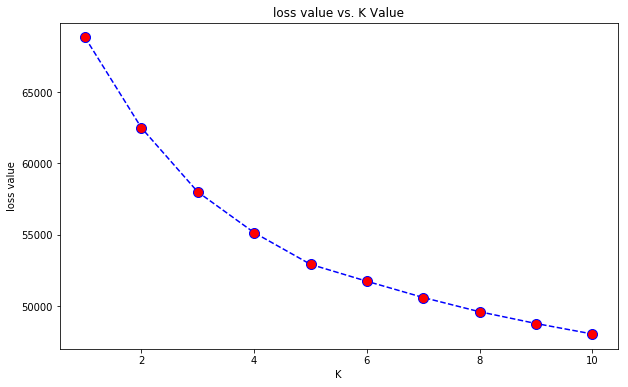

In [290]:
optimal_k(avgw2v_X_train)

In [34]:
from sklearn.cluster import KMeans

clf=KMeans(n_clusters=4)
clf.fit(avgw2v_X_train)
mydict = {i: np.where(clf.labels_ == i)[0] for i in range(4)}

word cluster for  1 cluster


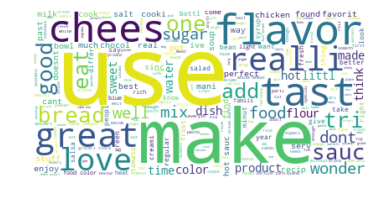

word cluster for  2 cluster


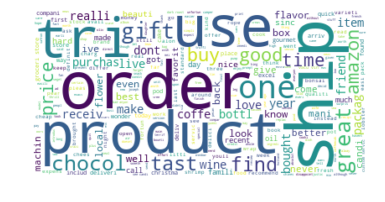

word cluster for  3 cluster


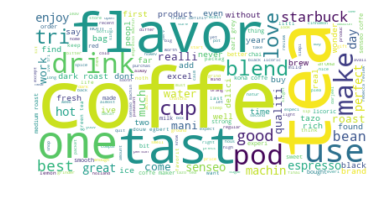

word cluster for  4 cluster


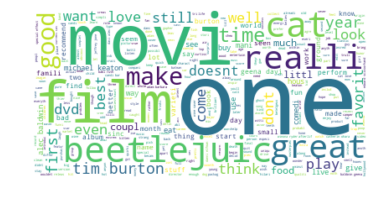

In [35]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


for i  in range (0,len(mydict)):
    wordlist=[]
    terms =list(mydict[i])
    for j in range(0,len(terms[0:100])):
        wordlist.append(X_train[terms[j]])
        
        
    
    wc = WordCloud(background_color="white", max_words=len(str(wordlist)), stopwords=stopwords)
    wc.generate(str(wordlist))
    print('word cluster for ',i+1 ,'cluster')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


<h3>Conclusions</h3>
<ol><li>
here first cluster represents food reviews of cheese, bread etc 
</li>
<li>
here second cluster represent  specific order reviews  etc
</li>
<li>here third cluster represents drink reviews
<li>
here fourth cluster represents movie reviews    </li>
</ol>

# TFIDF WORD 2 Vec

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer



In [37]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent100): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model100.wv[word]
#            
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:30<00:00, 175.24it/s]


In [39]:
final_tfidf_sample=tfidf_sent_vectors


In [40]:
X_train = final_tfidf_sample

In [41]:
from sklearn import preprocessing
tfidf_w2v_X_train= preprocessing.normalize(X_train)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 29.47s/it]


the minimum loss for each k value is :  [80875.094 74146.95  68405.456 65161.744 61970.29  60262.626 58679.711
 57472.46  56316.391 55406.14 ]
the most optimal value for k is :  5


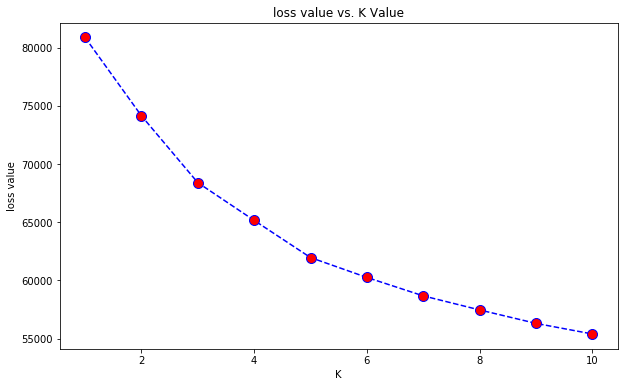

In [297]:
optimal_k(tfidf_w2v_X_train)

In [42]:
from sklearn.cluster import KMeans

clf=KMeans(n_clusters=5)
clf.fit(tfidf_w2v_X_train)
mydict = {i: np.where(clf.labels_ == i)[0] for i in range(5)}

# DBSCAN

In [16]:
sample=int((0.7*len(final['CleanedText'])))
sample

254919

In [17]:
X_train=final['CleanedText'].values[0:sample]

In [19]:
i=0
list_of_sent_full=[]
for sent in tqdm(X_train):
    
    list_of_sent_full.append(sent.split())

100%|███████████████████████████████████████████████████████████████████████| 254919/254919 [00:09<00:00, 28017.46it/s]


In [20]:
w2v_model_full = gensim.models.Word2Vec(list_of_sent_full,min_count=5,size=100, workers=4)

In [21]:
savetofile(list_of_sent_full,'list_of_sent_full')

In [97]:
list_of_sent_full = openfromfile('list_of_sent_full')

In [21]:
w2v_words = list(w2v_model_full.wv.vocab)


In [22]:
sent_vectors = []; 
for sent in tqdm(list_of_sent_full): 
    sent_vec = np.zeros(100)
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model_full.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [08:38<00:00, 491.70it/s]


254919
100


In [24]:
savetofile(sent_vectors,'sent_vectors_full')

In [25]:
final_w2v_sample_full = np.array(sent_vectors)
X_train = final_w2v_sample_full

In [26]:
from sklearn import preprocessing 
avgw2v_X_train= preprocessing.normalize(X_train)


In [107]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
nbrs=NearestNeighbors(n_neighbors=200).fit(avgw2v_X_train)
distances, indices = nbrs.kneighbors(avgw2v_X_train)

In [108]:
distancedec =sorted(distances[:,199],reverse=False)


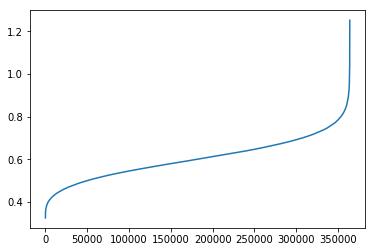

In [109]:
plt.plot(list(range(1,364172)), distancedec)

In [74]:
avgw2v_X_train=avgw2v_X_train[0:100000]

In [85]:
from sklearn.cluster import DBSCAN
avgw2v_X_train=avgw2v_X_train[0:100000]
clf = DBSCAN(min_samples=200,eps=0.8,n_jobs=-1)

clf.fit(avgw2v_X_train)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [67]:
savetofile(clf,'db_avgw2v')

In [69]:
clf = openfromfile('db_avgw2v')

In [70]:
labels = clf.labels_

In [71]:
len(labels)

100000

In [72]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

1

In [85]:
avgw2v_X_trainN =avgw2v_X_train[0:3000]

In [86]:
labelsN = labels[0:3000]

In [34]:
labels = clf.labels_

In [72]:
label_list=[]

In [73]:
 for i in clf.labels_ :
        if i==-1:
            
            label_list.append(1)
        else:
            label_list.append(0)

In [88]:
label_list = np.array(label_list)

In [87]:
clf.labels_

array([-1, -1, -1, ...,  0,  0,  0], dtype=int64)

In [91]:
label_list

array([1, 1, 1, ..., 0, 0, 0])

In [89]:
mydict = {i: np.where(label_list == i)[0] for i in range(2)}

In [90]:
mydict

{0: array([    7,     8,    10, ..., 99997, 99998, 99999], dtype=int64),
 1: array([    0,     1,     2, ..., 99719, 99785, 99955], dtype=int64)}

In [93]:
wordlist0=[]
for i in tqdm(range(0,len(mydict[0]))):
    wordlist0.append(X_train[mydict[0][i]])

100%|███████████████████████████████████████████████████████████████████████| 98429/98429 [00:00<00:00, 1147530.05it/s]


In [94]:
wordlist1=[]
for i in tqdm(range(0,len(mydict[1]))):
    wordlist1.append(X_train[mydict[1][i]])

100%|███████████████████████████████████████████████████████████████████████████| 1571/1571 [00:00<00:00, 32794.42it/s]


word cluster for first cluster


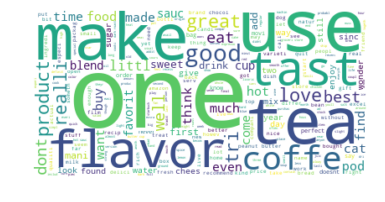

In [99]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


terms0 = list(wordlist0)
terms0 = terms0[0:500]
wc = WordCloud(background_color="white", max_words=len(str(terms0)), stopwords=stopwords)
wc.generate(str(terms0))
print('word cluster for first cluster')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
list1.clear()

Word Cluster for second cluster


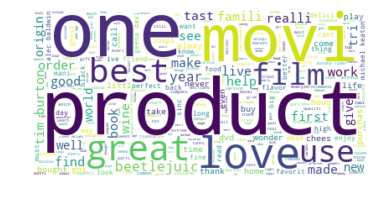

In [101]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


terms1 = list(wordlist1)
terms1 = terms1[0:500]
wc = WordCloud(background_color="white", max_words=len(str(terms1)), stopwords=stopwords)
wc.generate(str(terms1))
print("Word Cluster for second cluster")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
list1.clear()

<h3>Conclusions</h3>
<ol><li>
here first cluster represents drinks review 
</li>
<li>
here second cluster represent movie reviews etc
</li>
</ol>

# TFIDF W2v

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [17]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [24]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_full): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_full.wv[word]
#            
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [09:59<00:00, 434.21it/s]


In [25]:
final_tfidf_sample=tfidf_sent_vectors
X_train = final_tfidf_sample
from sklearn import preprocessing
tfidf_w2v_X_train= preprocessing.normalize(X_train)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
nbrs=NearestNeighbors(n_neighbors=200).fit(tfidf_w2v_X_train)
distances, indices = nbrs.kneighbors(tfidf_w2v_X_train)

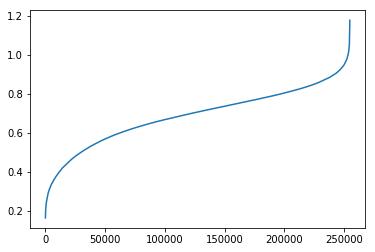

In [29]:
distancedec =sorted(distances[:,199],reverse=False)

plt.plot(list(range(1,254920)), distancedec)

In [26]:
tfidf_w2v_X_train = tfidf_w2v_X_train[0:100000]

In [27]:
from sklearn.cluster import DBSCAN
clf = DBSCAN(min_samples=100,eps=0.9)
clf.fit(tfidf_w2v_X_train)

DBSCAN(algorithm='auto', eps=0.9, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=200, n_jobs=1, p=None)

In [29]:
clf.labels_[500]

0

In [33]:
savetofile(clf,'db_tfidf_w2v')

In [72]:
clf = openfromfile('db_tfidf_w2v')

In [73]:
labels = clf.labels_

In [74]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


In [75]:
n_clusters_

1

In [45]:
label_list=[]
for i in clf.labels_ :
        if i==-1:
            label_list.append(1)
        else:
            label_list.append(0)

In [55]:
mydict = {i: np.where(clf.labels_== i)[0] for i in range(1)}

In [56]:
mydict

{0: array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64)}

In [58]:
wordlist0=[]
for i in tqdm(range(0,len(mydict[0]))):
    wordlist0.append(X_train[mydict[0][i]])

100%|█████████████████████████████████████████████████████████████████████████| 99677/99677 [00:03<00:00, 31524.50it/s]


word cluster for first cluster


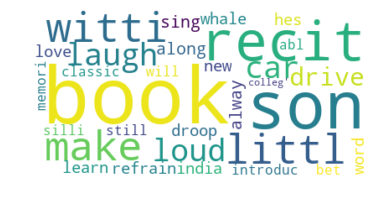

In [62]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


terms0 = list(wordlist0)
terms0 = terms0[0:1]
wc = WordCloud(background_color="white", max_words=len(str(terms0)), stopwords=stopwords)
wc.generate(str(terms0))
print('word cluster for first cluster')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


<h3>Conclusions</h3>
<ol><li>
here first cluster represents books review 
</li> </ol>


# Hierarichal based clustering

In [16]:
def optimalclusters(X_train):
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import AgglomerativeClustering
    K_values =list(range(2,11))
    max_value = []
    
    for k in tqdm(K_values):
        
        clustering = AgglomerativeClustering(n_clusters=k)
        
        pred=clustering.fit_predict(X_train)
        clf = silhouette_score(X_train,pred)
        max_value.append(clf)
    Max_value=[x for x in max_value]
    optimal_clusters = K_values[Max_value.index(max(Max_value))]
    print('\nThe optimal number of clusters is %d.' % optimal_clusters)

    plt.figure(figsize=(10,6))
    plt.plot(list(range(2,11)),Max_value,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Max value vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Max value')

    print("the Max value for each k value is : ", np.round(Max_value,3))    
            

In [68]:
final_sample =final['CleanedText'].values[0:5000]


In [69]:
X_train = final_sample

In [19]:
X_train

array(['witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg',
       'rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live',
       'beetlejuic well written movi everyth excel act special effect delight chose view movi',
       ...,
       'though quit high calori make refresh cup coffe hot summer afternoon',
       'huge fan tea drink one year astonish price great deal anyway must buy tea box one purchas love subtl flavor tea alway feel better drink cup even better add littl fresh organ lemon juic',
       'use everi day eat plain white jasmin rice sauc delici eat coconut rice delici eat ramen noodl instead powder flavor delici make orang tofu orang juic szechuan sauc marinad delici far favorit condiment spici hot wa

In [172]:
len(X_train)

5000

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,1))
Vocabulary = count_vect.fit_transform(X_train)

In [24]:
bow_X_train=count_vect.transform(X_train)


In [25]:
from sklearn import preprocessing 
bow_X_train= preprocessing.normalize(bow_X_train)


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [26:12<00:00, 175.08s/it]



The optimal number of clusters is 5.
the Max value for each k value is :  [0.007 0.008 0.009 0.009 0.009 0.007 0.006 0.005 0.005]


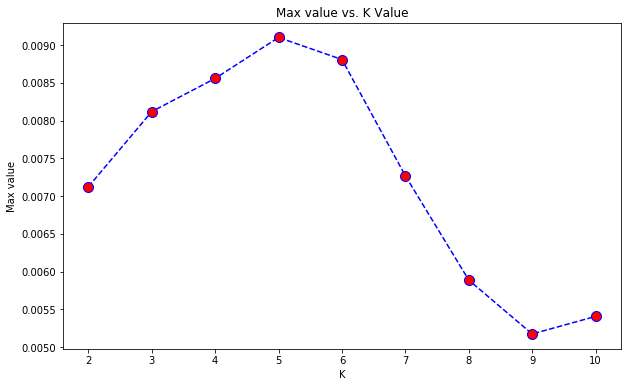

In [104]:
optimalclusters(bow_X_train)

In [26]:
from sklearn.cluster import AgglomerativeClustering
bow_X_train =bow_X_train.toarray()
clustering = AgglomerativeClustering(n_clusters=5)
clustering.fit(bow_X_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x000001EEB1F02EA0>)

In [27]:
mydict = {i: np.where(clustering.labels_ == i)[0] for i in range(5)}

In [223]:
dictlist = []
for key, value in mydict.items():
    
    temp = [key,value]
    dictlist.append(temp)

In [28]:
mydict

{0: array([   0,    1,    2, ..., 4996, 4997, 4999], dtype=int64),
 1: array([  69,   71,   93,  192,  256,  339,  340,  343,  347,  350,  352,
         354,  360,  363,  371,  392,  398,  400,  425,  426,  461,  463,
         464,  471,  480,  499,  503,  522,  547,  552,  574,  592,  595,
         614,  633,  637,  638,  655,  657,  669,  674,  693,  739,  766,
         775,  788,  835,  861,  862,  903,  910,  927, 1009, 1032, 1048,
        1058, 1086, 1090, 1103, 1124, 1148, 1173, 1190, 1197, 1202, 1232,
        1243, 1273, 1315, 1336, 1360, 1366, 1367, 1374, 1437, 1458, 1498,
        1519, 1521, 1534, 1536, 1557, 1565, 1585, 1591, 1596, 1625, 1658,
        1662, 1670, 1682, 1683, 1722, 1743, 1791, 1807, 1822, 1826, 1827,
        1843, 1853, 1944, 1960, 1962, 1968, 1981, 2084, 2099, 2104, 2110,
        2145, 2149, 2151, 2213, 2249, 2260, 2261, 2266, 2275, 2282, 2301,
        2307, 2308, 2315, 2329, 2331, 2332, 2356, 2358, 2361, 2376, 2383,
        2422, 2429, 2450, 2466, 2481, 2482

word cluster for  1 cluster


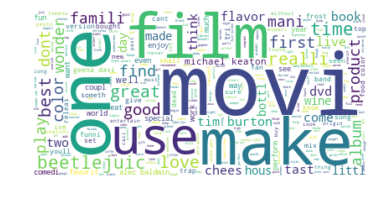

word cluster for  2 cluster


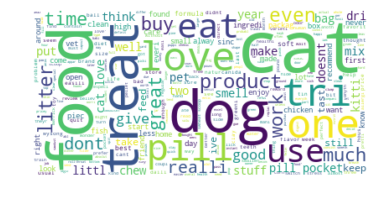

word cluster for  3 cluster


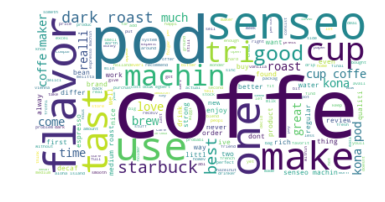

word cluster for  4 cluster


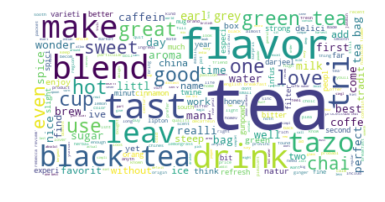

word cluster for  5 cluster


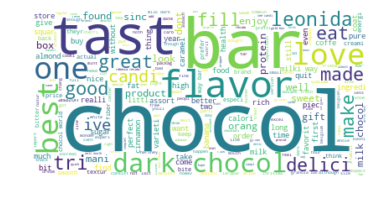

In [40]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


for i  in range (0,len(mydict)):
    wordlist=[]
    terms =list(mydict[i])
    for j in range(0,len(terms[0:100])):
        wordlist.append(X_train[terms[j]])
        
        
    
    wc = WordCloud(background_color="white", max_words=len(str(wordlist)), stopwords=stopwords)
    wc.generate(str(wordlist))
    print('word cluster for ',i+1 ,'cluster')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


<h3>Conclusions</h3>
<ol><li>
here first cluster represents movie ,books,film review 
</li>
<li>
here second cluster represent animal food etc
</li>
<li>here third cluster represents drink reviews
<li>
here fourth cluster represents drinks reviews    </li>
<li>
    here fifth cluster represents food reviews of chocolate etc</li></ol>

# TFIDF 

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
Vocabulary = tfidf_vect.fit_transform(X_train)


In [42]:
tfidf_X_train=tfidf_vect.transform(X_train)


In [43]:
from sklearn import preprocessing 
tfidf_X_train= preprocessing.normalize(tfidf_X_train)


In [44]:
tfidf_X_train.shape

(5000, 11508)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [30:24<00:00, 200.90s/it]



The optimal number of clusters is 3.
the Max value for each k value is :  [0.005 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006]


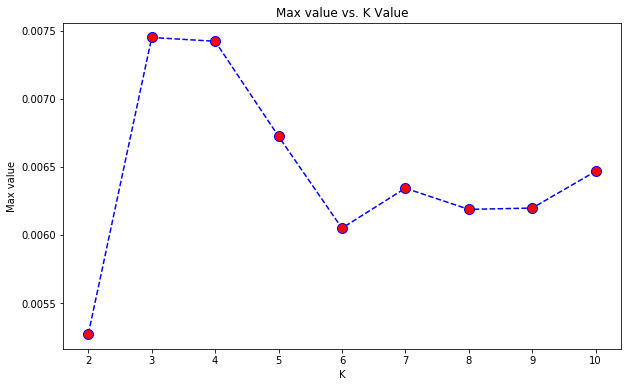

In [235]:
optimalclusters(tfidf_X_train)

In [45]:
from sklearn.cluster import AgglomerativeClustering
tfidf_X_train =tfidf_X_train.toarray()
clustering = AgglomerativeClustering(n_clusters=3)
clustering.fit(tfidf_X_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x000001EEB1F02EA0>)

In [46]:
mydict = {i: np.where(clustering.labels_ == i)[0] for i in range(3)}

In [47]:
mydict

{0: array([   0,    1,    2, ..., 4995, 4996, 4999], dtype=int64),
 1: array([  57,  100,  102,  128,  141,  143,  147,  149,  152,  159,  160,
         168,  183,  184,  196,  205,  211,  214,  222,  225,  231,  240,
         241,  246,  248,  276,  285,  311,  312,  328,  375,  403,  406,
         408,  432,  433,  450,  472,  488,  491,  508,  517,  526,  527,
         528,  530,  541,  543,  553,  560,  570,  571,  575,  580,  617,
         624,  630,  632,  634,  636,  639,  640,  641,  647,  648,  649,
         650,  687,  691,  723,  732,  733,  741,  745,  747,  750,  757,
         763,  765,  828,  830,  841,  873,  882,  884,  889,  901,  902,
         912,  925,  939,  951,  954,  958,  996, 1022, 1033, 1034, 1036,
        1059, 1062, 1079, 1105, 1141, 1163, 1180, 1183, 1206, 1207, 1215,
        1223, 1259, 1263, 1272, 1312, 1318, 1334, 1384, 1391, 1394, 1396,
        1405, 1410, 1422, 1431, 1433, 1440, 1443, 1447, 1448, 1449, 1450,
        1451, 1456, 1474, 1488, 1505, 1509

word cluster for  1 cluster


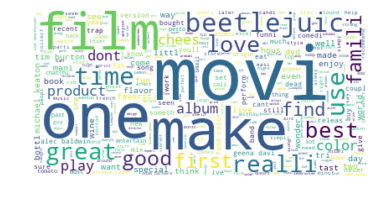

word cluster for  2 cluster


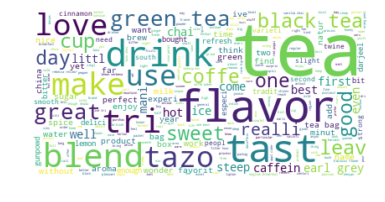

word cluster for  3 cluster


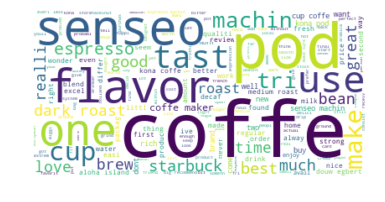

In [48]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


for i  in range (0,len(mydict)):
    wordlist=[]
    terms =list(mydict[i])
    for j in range(0,len(terms[0:100])):
        wordlist.append(X_train[terms[j]])
        
        
    
    wc = WordCloud(background_color="white", max_words=len(str(wordlist)), stopwords=stopwords)
    wc.generate(str(wordlist))
    print('word cluster for ',i+1 ,'cluster')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

<h3>Conclusions</h3>
<ol><li>
here first cluster represents movie ,books,film review 
</li>
<li>
here second cluster represent taste reviews of coffee , tea etc
</li>
<li>her ethird cluster represents drinks reviews    </li>
</ol>

# word 2 vec

In [49]:
i=0
list_of_sent_agg=[]
for sent in tqdm(X_train):
    
    list_of_sent_agg.append(sent.split())

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3240.03it/s]


In [50]:
w2v_model_agg = gensim.models.Word2Vec(list_of_sent_agg,min_count=5,size=100, workers=4)

In [51]:
savetofile(list_of_sent_agg,'list_of_sent_agg')

In [52]:
w2v_words = list(w2v_model_agg.wv.vocab)


In [53]:
sent_vectors = []; 
for sent in tqdm(list_of_sent_agg): 
    sent_vec = np.zeros(100)
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model_agg.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 655.14it/s]


5000
100


In [54]:
X_train=sent_vectors

In [55]:
from sklearn import preprocessing 
avgw2v_X_train= preprocessing.normalize(X_train)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.41s/it]



The optimal number of clusters is 2.
the Max value for each k value is :  [0.301 0.29  0.19  0.212 0.187 0.179 0.184 0.176 0.174]


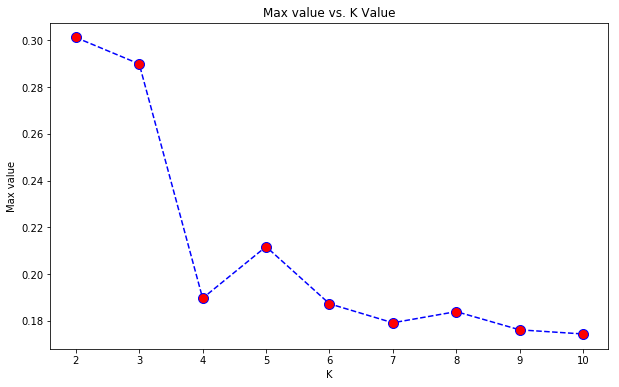

In [248]:
optimalclusters(avgw2v_X_train)

In [56]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=2)
clustering.fit(avgw2v_X_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000001EEB1F02EA0>)

In [57]:
mydict = {i: np.where(clustering.labels_ == i)[0] for i in range(2)}

In [58]:
mydict

{0: array([   3,    4,    5, ..., 4997, 4998, 4999], dtype=int64),
 1: array([   0,    1,    2, ..., 4986, 4991, 4993], dtype=int64)}

word cluster for  1 cluster


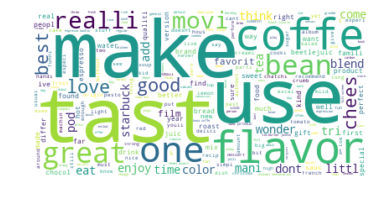

word cluster for  2 cluster


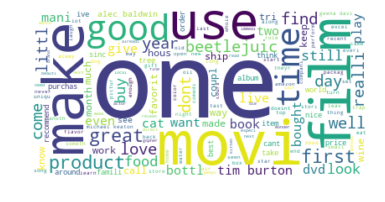

In [62]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


for i  in range (0,len(mydict)):
    wordlist=[]
    terms =list(mydict[i])
    for j in range(0,len(terms[0:100])):
        wordlist.append(X_train[terms[j]])
        
        
    
    wc = WordCloud(background_color="white", max_words=len(str(wordlist)), stopwords=stopwords)
    wc.generate(str(wordlist))
    print('word cluster for ',i+1 ,'cluster')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

<h3>Conclusions</h3>
<ol><li>
here first cluster representsfood tatse review 
</li>
<li>
here second cluster represent movie etc
</li>
</ol>

# TFIDF W2V

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [64]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_agg): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_agg.wv[word]
#            
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 604.25it/s]


In [65]:
X_train=tfidf_sent_vectors
from sklearn import preprocessing 
tfidfw2v_X_train= preprocessing.normalize(X_train)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.21s/it]



The optimal number of clusters is 2.
the Max value for each k value is :  [0.301 0.295 0.241 0.275 0.267 0.269 0.238 0.17  0.167]


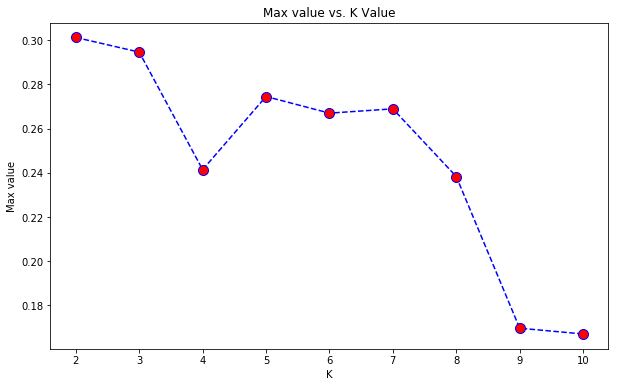

In [259]:
optimalclusters(tfidfw2v_X_train)

In [66]:
mydict = {i: np.where(clustering.labels_ == i)[0] for i in range(2)}

word cluster for  1 cluster


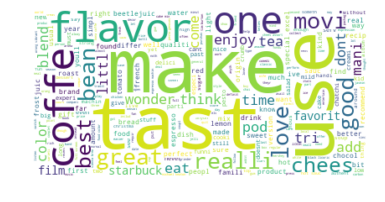

word cluster for  2 cluster


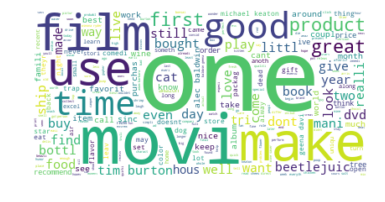

In [70]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


for i  in range (0,len(mydict)):
    wordlist=[]
    terms =list(mydict[i])
    for j in range(0,len(terms[0:100])):
        wordlist.append(X_train[terms[j]])
        
        
    
    wc = WordCloud(background_color="white", max_words=len(str(wordlist)), stopwords=stopwords)
    wc.generate(str(wordlist))
    print('word cluster for ',i+1 ,'cluster')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

<h3>Conclusions</h3>
<ol><li>
here first cluster represents drink review 
</li>
<li>
here second cluster represent movie reviews etc
</li></ol>

# SUMMARY

<ol>
<li>
i have performed kmeans clustering  on amazon fine food reviews </li>
    <li>
    i have used multiple kmeans technique i.e dbscan , hierarichal and normal clustering
        </li>
    <li>
    i have used hyperparameter tuning to find the best k (i.e no. of cluster)
        </li>
    <li>
    i have plotted wordcloud for each vectorization
        </li>
    <li>
    i have seen close results like film and movi in same cluster
</li></ol>